In [1]:
import torchvision.models as models
import torch.onnx as onnx
import torch

/opt/conda/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import PIL
import time
import cv2
import os

In [3]:
from models.experimental import attempt_load
from utils.datasets import letterbox
from utils.general import check_img_size, non_max_suppression_face, apply_classifier, scale_coords, xywh2xyxy, xyxy2xywh, \
    strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized

In [4]:
def make_dir(dirName):
    # Create a target directory & all intermediate 
    # directories if they don't exists
    
    if not os.path.exists(dirName):
        os.makedirs(dirName, exist_ok = True)
        print("[INFO] Directory " ,dirName,  " created")
    else:
        print("[INFO] Directory " ,dirName,  " already exists") 

In [5]:
exp_id = 999            # experiment ID
iou_thr = 0.5           # IoU threshold
con_thr = 0.5           # confidence threshold
img_size = 640          # image sizes used at evaluation

set_ = 'test'            # val / test / train
weights = "/workspace/yolov5-face-my/runs/train/exp1_l6/weights/best.pt"    # path to the model weights

# dataset directories
ic_dir = '/workspace/dataset/icartoon/'
aw_dir = '/workspace/dataset/animalweb/'
tf_dir = '/workspace/dataset/tfw_split/'

# Get paths to the dataset images
ic_paths = list(paths.list_images(os.path.join(ic_dir, set_, 'images')))
aw_paths = list(paths.list_images(os.path.join(aw_dir, set_, 'images')))
tfi_paths = list(paths.list_images(os.path.join(tf_dir, set_, 'indoor', 'images')))
tfo_paths = list(paths.list_images(os.path.join(tf_dir, set_, 'outdoor', 'images')))
print("iCartoonFace {} set size: {}". format(set_, len(ic_paths)))
print("AnimalWeb {} set size: {}". format(set_, len(aw_paths)))
print("TFW-indoor {} set size: {}". format(set_, len(tfi_paths)))
print("TFW-outdoor {} set size: {}". format(set_, len(tfo_paths)))

# Create directories for saving evaluation results
ic_res_path = "Object-Detection-Metrics/results/{}/exp_{}/icartoon/detections_{}_{}".format(set_, exp_id, 
                                                                                         int(iou_thr * 100),
                                                                                         int(con_thr * 100))
aw_res_path = "Object-Detection-Metrics/results/{}/exp_{}/animalweb/detections_{}_{}".format(set_, exp_id, 
                                                                                         int(iou_thr * 100),
                                                                                         int(con_thr * 100))
tfi_res_path = "Object-Detection-Metrics/results/{}/exp_{}/tfw_i/detections_{}_{}".format(set_, exp_id, 
                                                                                         int(iou_thr * 100),
                                                                                         int(con_thr * 100))
tfo_res_path = "Object-Detection-Metrics/results/{}/exp_{}/tfw_o/detections_{}_{}".format(set_, exp_id, 
                                                                                         int(iou_thr * 100),
                                                                                         int(con_thr * 100))
make_dir(ic_res_path)
make_dir(aw_res_path)
make_dir(tfi_res_path)
make_dir(tfo_res_path)

iCartoonFace test set size: 10000
AnimalWeb test set size: 3752
TFW-indoor test set size: 1080
TFW-outdoor test set size: 800
[INFO] Directory  Object-Detection-Metrics/results/test/exp_999/icartoon/detections_50_50  created
[INFO] Directory  Object-Detection-Metrics/results/test/exp_999/animalweb/detections_50_50  created
[INFO] Directory  Object-Detection-Metrics/results/test/exp_999/tfw_i/detections_50_50  created
[INFO] Directory  Object-Detection-Metrics/results/test/exp_999/tfw_o/detections_50_50  created


In [6]:
# Load weights 
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = attempt_load(weights, map_location=device)
device, weights

Fusing layers... 


(device(type='cuda', index=1),
 '/workspace/yolov5-face-my/runs/train/exp1_l6/weights/best.pt')

In [7]:
def scale_coords_landmarks(img1_shape, coords, img0_shape, ratio_pad=None):
    # Rescale coords (xyxy) from img1_shape to img0_shape
    
    if ratio_pad is None:  # calculate from img0_shape
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    coords[:, [0, 2, 4, 6, 8]] -= pad[0]  # x padding
    coords[:, [1, 3, 5, 7, 9]] -= pad[1]  # y padding
    coords[:, :10] /= gain
    coords[:, 0].clamp_(0, img0_shape[1])  # x1
    coords[:, 1].clamp_(0, img0_shape[0])  # y1
    coords[:, 2].clamp_(0, img0_shape[1])  # x2
    coords[:, 3].clamp_(0, img0_shape[0])  # y2
    coords[:, 4].clamp_(0, img0_shape[1])  # x3
    coords[:, 5].clamp_(0, img0_shape[0])  # y3
    coords[:, 6].clamp_(0, img0_shape[1])  # x4
    coords[:, 7].clamp_(0, img0_shape[0])  # y4
    coords[:, 8].clamp_(0, img0_shape[1])  # x5
    coords[:, 9].clamp_(0, img0_shape[0])  # y5
    
    return coords

In [8]:
def show_results(img, xywh, conf, landmarks):
    # Draw detected bounding box with landmarks
    
    h,w,c = img.shape
    
    tl = 1 or round(0.002 * (h + w) / 2) + 1    # line/font thickness
    clors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(0,255,255)]    # colors for landmarks

    # Convert YOLO coordinates to x1, y1, x2, y2 format
    x1 = int(xywh[0] * w - 0.5 * xywh[2] * w)
    y1 = int(xywh[1] * h - 0.5 * xywh[3] * h)
    x2 = int(xywh[0] * w + 0.5 * xywh[2] * w)
    y2 = int(xywh[1] * h + 0.5 * xywh[3] * h)
    
    # Draw bounding box
    cv2.rectangle(img, (x1,y1), (x2, y2), (0,255,0), thickness=tl, lineType=cv2.LINE_AA)

    # Draw facial landmarks
    for i in range(5):
        point_x = int(landmarks[2 * i] * w)
        point_y = int(landmarks[2 * i + 1] * h)
        cv2.circle(img, (point_x, point_y), tl+1, clors[i], -1)

    # Put confidence threshold
    tf = max(tl - 1, 1)  # font thickness
    label = str(conf)[:5]
    cv2.putText(img, label, (x1, y1 - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    
    return img

In [9]:
def detect_one(model, image_path, device, imgsz=640, conf_thres=0.5, iou_thres=0.5, augment=None, show=False):
    # Detect face region and facial landmarks on given images
    
    # Load image and create a copy
    orgimg = cv2.imread(image_path)
    img0 = orgimg.copy()
    
    # Preprocess the image     
    stride = int(model.stride.max())    
    if imgsz <= 0:                    
        imgsz = dynamic_resize(img0.shape)
    imgsz = check_img_size(imgsz, s=64)
    img = letterbox(img0, imgsz)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device)
    img = img.float()
    img /= 255.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)

    # Inference
    if augment is not None:
        pred = model(img, augment=True, aug_setting=augment)[0]
    else:
        pred = model(img, augment=False)[0]   
    
    # Apply non max suppression
    pred = non_max_suppression_face(pred, conf_thres, iou_thres)[0]
    gn = torch.tensor(img0.shape)[[1, 0, 1, 0]].to(device)                        # normalization gain whwh
    gn_lks = torch.tensor(img0.shape)[[1, 0, 1, 0, 1, 0, 1, 0, 1, 0]].to(device)  # normalization gain landmarks
    
    # Scale and store predictions
    boxes = []
    landmarks = []
    conf_scores = []
    h, w, c = img0.shape
    if pred is not None:
        pred[:, :4] = scale_coords(img.shape[2:], pred[:, :4], img0.shape).round()
        pred[:, 5:15] = scale_coords_landmarks(img.shape[2:], pred[:, 5:15], img0.shape).round()
        for j in range(pred.size()[0]):
            xywh = (xyxy2xywh(pred[j, :4].view(1, 4)) / gn).view(-1)
            xywh = xywh.data.cpu().numpy()
            conf = pred[j, 4].cpu().numpy()
            points = (pred[j, 5:15].view(1, 10) / gn_lks).view(-1).tolist()
            class_num = pred[j, 15].cpu().numpy()
            x1 = int(xywh[0] * w - 0.5 * xywh[2] * w)
            y1 = int(xywh[1] * h - 0.5 * xywh[3] * h)
            x2 = int(xywh[0] * w + 0.5 * xywh[2] * w)
            y2 = int(xywh[1] * h + 0.5 * xywh[3] * h)
                
            boxes.append([x1, y1, x2-x1, y2-y1])
            landmarks.append(points)
            conf_scores.append(conf)
            
            if show:
                orgimg = show_results(orgimg, xywh, conf, points)
            
    if show:
        img = PIL.Image.fromarray(cv2.cvtColor(orgimg, cv2.COLOR_BGR2RGB))
        img.show()
        
    return boxes, landmarks, conf_scores

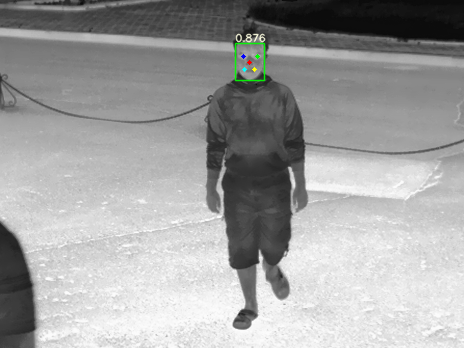

([[235, 43, 29, 37]],
 [[0.5237069129943848,
   0.16091954708099365,
   0.5538793206214905,
   0.16091954708099365,
   0.5387930870056152,
   0.18103447556495667,
   0.5280172228813171,
   0.1982758641242981,
   0.5495689511299133,
   0.1982758641242981]],
 [array(    0.87606, dtype=float32)])

In [11]:
detect_one(model, tfo_paths[1], device, imgsz=img_size, show=True)

In [12]:
def evaluate(imagePaths, res_path, model, device, img_size, con_thr, iou_thr, augment=None):
    # Evaluate model performance on a dataset
    
    for ind, imagePath in enumerate(imagePaths, 1):
        print("Processing image: {}/{}".format(ind, len(imagePaths)))
        
        # Detect
        boxes, pred_landmarks, scores = detect_one(model, imagePath, device, 
                                                                 img_size, con_thr, iou_thr, augment=augment)

        # Open the file to  write the results in absolute Object-Detection-Metrics format
        # "face [conf_score] [x1] [x2] [w] [h]"        
        imageName = imagePath.split('/')[-1].split('.')[0]
        det_file = open("{}/{}.txt".format(res_path, imageName), "w")
    
        # Iterate through the detected bounding boxes and conf scores
        # and write to the txt file
        for pred_box, conf_score in zip(boxes, scores):
            det_file.write('face')
            det_file.write(" ")
            det_file.write(str(conf_score))
            det_file.write(" ")
            det_file.write(str(pred_box[0]))
            det_file.write(" ")
            det_file.write(str(pred_box[1]))
            det_file.write(" ")
            det_file.write(str(pred_box[2]))
            det_file.write(" ")
            det_file.write(str(pred_box[3]))
            det_file.write("\n")
                
        det_file.close()

In [13]:
evaluate(tfo_paths, tfo_res_path, model, device, img_size, con_thr, iou_thr, augment=2)

Processing image: 1/800
Processing image: 2/800
Processing image: 3/800
Processing image: 4/800
Processing image: 5/800
Processing image: 6/800
Processing image: 7/800
Processing image: 8/800
Processing image: 9/800
Processing image: 10/800
Processing image: 11/800
Processing image: 12/800
Processing image: 13/800
Processing image: 14/800
Processing image: 15/800
Processing image: 16/800
Processing image: 17/800
Processing image: 18/800
Processing image: 19/800
Processing image: 20/800
Processing image: 21/800
Processing image: 22/800
Processing image: 23/800
Processing image: 24/800
Processing image: 25/800
Processing image: 26/800
Processing image: 27/800
Processing image: 28/800
Processing image: 29/800
Processing image: 30/800
Processing image: 31/800
Processing image: 32/800
Processing image: 33/800
Processing image: 34/800
Processing image: 35/800
Processing image: 36/800
Processing image: 37/800
Processing image: 38/800
Processing image: 39/800
Processing image: 40/800
Processin

KeyboardInterrupt: 

In [15]:
evaluate(tfi_paths, tfi_res_path, model, device, img_size, con_thr, iou_thr)

Processing image: 1/432
Processing image: 2/432
Processing image: 3/432
Processing image: 4/432
Processing image: 5/432
Processing image: 6/432
Processing image: 7/432
Processing image: 8/432
Processing image: 9/432
Processing image: 10/432
Processing image: 11/432
Processing image: 12/432
Processing image: 13/432
Processing image: 14/432
Processing image: 15/432
Processing image: 16/432
Processing image: 17/432
Processing image: 18/432
Processing image: 19/432
Processing image: 20/432
Processing image: 21/432
Processing image: 22/432
Processing image: 23/432
Processing image: 24/432
Processing image: 25/432
Processing image: 26/432
Processing image: 27/432
Processing image: 28/432
Processing image: 29/432
Processing image: 30/432
Processing image: 31/432
Processing image: 32/432
Processing image: 33/432
Processing image: 34/432
Processing image: 35/432
Processing image: 36/432
Processing image: 37/432
Processing image: 38/432
Processing image: 39/432
Processing image: 40/432
Processin

Processing image: 321/432
Processing image: 322/432
Processing image: 323/432
Processing image: 324/432
Processing image: 325/432
Processing image: 326/432
Processing image: 327/432
Processing image: 328/432
Processing image: 329/432
Processing image: 330/432
Processing image: 331/432
Processing image: 332/432
Processing image: 333/432
Processing image: 334/432
Processing image: 335/432
Processing image: 336/432
Processing image: 337/432
Processing image: 338/432
Processing image: 339/432
Processing image: 340/432
Processing image: 341/432
Processing image: 342/432
Processing image: 343/432
Processing image: 344/432
Processing image: 345/432
Processing image: 346/432
Processing image: 347/432
Processing image: 348/432
Processing image: 349/432
Processing image: 350/432
Processing image: 351/432
Processing image: 352/432
Processing image: 353/432
Processing image: 354/432
Processing image: 355/432
Processing image: 356/432
Processing image: 357/432
Processing image: 358/432
Processing i

In [16]:
evaluate(aw_paths, aw_res_path, model, device, img_size, con_thr, iou_thr)

Processing image: 1/2062
Processing image: 2/2062
Processing image: 3/2062
Processing image: 4/2062
Processing image: 5/2062
Processing image: 6/2062
Processing image: 7/2062
Processing image: 8/2062
Processing image: 9/2062
Processing image: 10/2062
Processing image: 11/2062
Processing image: 12/2062
Processing image: 13/2062
Processing image: 14/2062
Processing image: 15/2062
Processing image: 16/2062
Processing image: 17/2062
Processing image: 18/2062
Processing image: 19/2062
Processing image: 20/2062
Processing image: 21/2062
Processing image: 22/2062
Processing image: 23/2062
Processing image: 24/2062
Processing image: 25/2062
Processing image: 26/2062


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


Processing image: 27/2062
Processing image: 28/2062
Processing image: 29/2062
Processing image: 30/2062
Processing image: 31/2062
Processing image: 32/2062
Processing image: 33/2062
Processing image: 34/2062
Processing image: 35/2062
Processing image: 36/2062
Processing image: 37/2062
Processing image: 38/2062
Processing image: 39/2062
Processing image: 40/2062
Processing image: 41/2062
Processing image: 42/2062
Processing image: 43/2062
Processing image: 44/2062
Processing image: 45/2062
Processing image: 46/2062
Processing image: 47/2062
Processing image: 48/2062
Processing image: 49/2062
Processing image: 50/2062
Processing image: 51/2062
Processing image: 52/2062
Processing image: 53/2062
Processing image: 54/2062
Processing image: 55/2062
Processing image: 56/2062
Processing image: 57/2062
Processing image: 58/2062
Processing image: 59/2062
Processing image: 60/2062
Processing image: 61/2062
Processing image: 62/2062
Processing image: 63/2062
Processing image: 64/2062
Processing i

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in less


Processing image: 162/2062
Processing image: 163/2062
Processing image: 164/2062
Processing image: 165/2062
Processing image: 166/2062
Processing image: 167/2062
Processing image: 168/2062
Processing image: 169/2062
Processing image: 170/2062
Processing image: 171/2062
Processing image: 172/2062
Processing image: 173/2062
Processing image: 174/2062
Processing image: 175/2062
Processing image: 176/2062
Processing image: 177/2062
Processing image: 178/2062
Processing image: 179/2062
Processing image: 180/2062
Processing image: 181/2062
Processing image: 182/2062
Processing image: 183/2062
Processing image: 184/2062
Processing image: 185/2062
Processing image: 186/2062
Processing image: 187/2062
Processing image: 188/2062
Processing image: 189/2062
Processing image: 190/2062
Processing image: 191/2062
Processing image: 192/2062
Processing image: 193/2062
Processing image: 194/2062
Processing image: 195/2062
Processing image: 196/2062
Processing image: 197/2062
Processing image: 198/2062
P

Processing image: 466/2062
Processing image: 467/2062
Processing image: 468/2062
Processing image: 469/2062
Processing image: 470/2062
Processing image: 471/2062
Processing image: 472/2062
Processing image: 473/2062
Processing image: 474/2062
Processing image: 475/2062
Processing image: 476/2062
Processing image: 477/2062
Processing image: 478/2062
Processing image: 479/2062
Processing image: 480/2062
Processing image: 481/2062
Processing image: 482/2062
Processing image: 483/2062
Processing image: 484/2062
Processing image: 485/2062
Processing image: 486/2062
Processing image: 487/2062
Processing image: 488/2062
Processing image: 489/2062
Processing image: 490/2062
Processing image: 491/2062
Processing image: 492/2062
Processing image: 493/2062
Processing image: 494/2062
Processing image: 495/2062
Processing image: 496/2062
Processing image: 497/2062
Processing image: 498/2062
Processing image: 499/2062
Processing image: 500/2062
Processing image: 501/2062
Processing image: 502/2062
P

Processing image: 770/2062
Processing image: 771/2062
Processing image: 772/2062
Processing image: 773/2062
Processing image: 774/2062
Processing image: 775/2062
Processing image: 776/2062
Processing image: 777/2062
Processing image: 778/2062
Processing image: 779/2062
Processing image: 780/2062
Processing image: 781/2062
Processing image: 782/2062
Processing image: 783/2062
Processing image: 784/2062
Processing image: 785/2062
Processing image: 786/2062
Processing image: 787/2062
Processing image: 788/2062
Processing image: 789/2062
Processing image: 790/2062
Processing image: 791/2062
Processing image: 792/2062
Processing image: 793/2062
Processing image: 794/2062
Processing image: 795/2062
Processing image: 796/2062
Processing image: 797/2062
Processing image: 798/2062
Processing image: 799/2062
Processing image: 800/2062
Processing image: 801/2062
Processing image: 802/2062
Processing image: 803/2062
Processing image: 804/2062
Processing image: 805/2062
Processing image: 806/2062
P

Processing image: 1071/2062
Processing image: 1072/2062
Processing image: 1073/2062
Processing image: 1074/2062
Processing image: 1075/2062
Processing image: 1076/2062
Processing image: 1077/2062
Processing image: 1078/2062
Processing image: 1079/2062
Processing image: 1080/2062
Processing image: 1081/2062
Processing image: 1082/2062
Processing image: 1083/2062
Processing image: 1084/2062
Processing image: 1085/2062
Processing image: 1086/2062
Processing image: 1087/2062
Processing image: 1088/2062
Processing image: 1089/2062
Processing image: 1090/2062
Processing image: 1091/2062
Processing image: 1092/2062
Processing image: 1093/2062
Processing image: 1094/2062
Processing image: 1095/2062
Processing image: 1096/2062
Processing image: 1097/2062
Processing image: 1098/2062
Processing image: 1099/2062
Processing image: 1100/2062
Processing image: 1101/2062
Processing image: 1102/2062
Processing image: 1103/2062
Processing image: 1104/2062
Processing image: 1105/2062
Processing image: 11

Processing image: 1364/2062
Processing image: 1365/2062
Processing image: 1366/2062
Processing image: 1367/2062
Processing image: 1368/2062
Processing image: 1369/2062
Processing image: 1370/2062
Processing image: 1371/2062
Processing image: 1372/2062
Processing image: 1373/2062
Processing image: 1374/2062
Processing image: 1375/2062
Processing image: 1376/2062
Processing image: 1377/2062
Processing image: 1378/2062
Processing image: 1379/2062
Processing image: 1380/2062
Processing image: 1381/2062
Processing image: 1382/2062
Processing image: 1383/2062
Processing image: 1384/2062
Processing image: 1385/2062
Processing image: 1386/2062
Processing image: 1387/2062
Processing image: 1388/2062
Processing image: 1389/2062
Processing image: 1390/2062
Processing image: 1391/2062
Processing image: 1392/2062
Processing image: 1393/2062
Processing image: 1394/2062
Processing image: 1395/2062
Processing image: 1396/2062
Processing image: 1397/2062
Processing image: 1398/2062
Processing image: 13

Processing image: 1657/2062
Processing image: 1658/2062
Processing image: 1659/2062
Processing image: 1660/2062
Processing image: 1661/2062
Processing image: 1662/2062
Processing image: 1663/2062
Processing image: 1664/2062
Processing image: 1665/2062
Processing image: 1666/2062
Processing image: 1667/2062
Processing image: 1668/2062
Processing image: 1669/2062
Processing image: 1670/2062
Processing image: 1671/2062
Processing image: 1672/2062
Processing image: 1673/2062
Processing image: 1674/2062
Processing image: 1675/2062
Processing image: 1676/2062
Processing image: 1677/2062
Processing image: 1678/2062
Processing image: 1679/2062
Processing image: 1680/2062
Processing image: 1681/2062
Processing image: 1682/2062
Processing image: 1683/2062
Processing image: 1684/2062
Processing image: 1685/2062
Processing image: 1686/2062
Processing image: 1687/2062
Processing image: 1688/2062
Processing image: 1689/2062
Processing image: 1690/2062
Processing image: 1691/2062
Processing image: 16

Processing image: 1950/2062
Processing image: 1951/2062
Processing image: 1952/2062
Processing image: 1953/2062
Processing image: 1954/2062
Processing image: 1955/2062
Processing image: 1956/2062
Processing image: 1957/2062
Processing image: 1958/2062
Processing image: 1959/2062
Processing image: 1960/2062
Processing image: 1961/2062
Processing image: 1962/2062
Processing image: 1963/2062
Processing image: 1964/2062
Processing image: 1965/2062
Processing image: 1966/2062
Processing image: 1967/2062
Processing image: 1968/2062
Processing image: 1969/2062
Processing image: 1970/2062
Processing image: 1971/2062
Processing image: 1972/2062
Processing image: 1973/2062
Processing image: 1974/2062
Processing image: 1975/2062
Processing image: 1976/2062
Processing image: 1977/2062
Processing image: 1978/2062
Processing image: 1979/2062
Processing image: 1980/2062
Processing image: 1981/2062
Processing image: 1982/2062
Processing image: 1983/2062
Processing image: 1984/2062
Processing image: 19

In [17]:
evaluate(ic_paths, ic_res_path, model, device, img_size, con_thr, iou_thr)

Processing image: 1/5000
Processing image: 2/5000
Processing image: 3/5000
Processing image: 4/5000
Processing image: 5/5000
Processing image: 6/5000
Processing image: 7/5000
Processing image: 8/5000
Processing image: 9/5000
Processing image: 10/5000
Processing image: 11/5000
Processing image: 12/5000
Processing image: 13/5000
Processing image: 14/5000
Processing image: 15/5000
Processing image: 16/5000
Processing image: 17/5000
Processing image: 18/5000
Processing image: 19/5000
Processing image: 20/5000
Processing image: 21/5000
Processing image: 22/5000
Processing image: 23/5000
Processing image: 24/5000
Processing image: 25/5000
Processing image: 26/5000
Processing image: 27/5000
Processing image: 28/5000
Processing image: 29/5000
Processing image: 30/5000


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in less


Processing image: 31/5000
Processing image: 32/5000
Processing image: 33/5000
Processing image: 34/5000
Processing image: 35/5000
Processing image: 36/5000
Processing image: 37/5000
Processing image: 38/5000
Processing image: 39/5000
Processing image: 40/5000
Processing image: 41/5000
Processing image: 42/5000
Processing image: 43/5000
Processing image: 44/5000
Processing image: 45/5000
Processing image: 46/5000
Processing image: 47/5000
Processing image: 48/5000
Processing image: 49/5000
Processing image: 50/5000
Processing image: 51/5000
Processing image: 52/5000
Processing image: 53/5000
Processing image: 54/5000
Processing image: 55/5000
Processing image: 56/5000
Processing image: 57/5000
Processing image: 58/5000
Processing image: 59/5000
Processing image: 60/5000
Processing image: 61/5000
Processing image: 62/5000
Processing image: 63/5000
Processing image: 64/5000
Processing image: 65/5000
Processing image: 66/5000
Processing image: 67/5000
Processing image: 68/5000
Processing i

Processing image: 338/5000
Processing image: 339/5000
Processing image: 340/5000
Processing image: 341/5000
Processing image: 342/5000
Processing image: 343/5000
Processing image: 344/5000
Processing image: 345/5000
Processing image: 346/5000
Processing image: 347/5000
Processing image: 348/5000
Processing image: 349/5000
Processing image: 350/5000
Processing image: 351/5000
Processing image: 352/5000
Processing image: 353/5000
Processing image: 354/5000
Processing image: 355/5000
Processing image: 356/5000
Processing image: 357/5000
Processing image: 358/5000
Processing image: 359/5000
Processing image: 360/5000
Processing image: 361/5000
Processing image: 362/5000
Processing image: 363/5000
Processing image: 364/5000
Processing image: 365/5000
Processing image: 366/5000
Processing image: 367/5000
Processing image: 368/5000
Processing image: 369/5000
Processing image: 370/5000
Processing image: 371/5000
Processing image: 372/5000
Processing image: 373/5000
Processing image: 374/5000
P

Processing image: 642/5000
Processing image: 643/5000
Processing image: 644/5000
Processing image: 645/5000
Processing image: 646/5000
Processing image: 647/5000
Processing image: 648/5000
Processing image: 649/5000
Processing image: 650/5000
Processing image: 651/5000
Processing image: 652/5000
Processing image: 653/5000
Processing image: 654/5000
Processing image: 655/5000
Processing image: 656/5000
Processing image: 657/5000
Processing image: 658/5000
Processing image: 659/5000
Processing image: 660/5000
Processing image: 661/5000
Processing image: 662/5000
Processing image: 663/5000
Processing image: 664/5000
Processing image: 665/5000
Processing image: 666/5000
Processing image: 667/5000
Processing image: 668/5000
Processing image: 669/5000
Processing image: 670/5000
Processing image: 671/5000
Processing image: 672/5000
Processing image: 673/5000
Processing image: 674/5000
Processing image: 675/5000
Processing image: 676/5000
Processing image: 677/5000
Processing image: 678/5000
P

Processing image: 947/5000
Processing image: 948/5000
Processing image: 949/5000
Processing image: 950/5000
Processing image: 951/5000
Processing image: 952/5000
Processing image: 953/5000
Processing image: 954/5000
Processing image: 955/5000
Processing image: 956/5000
Processing image: 957/5000
Processing image: 958/5000
Processing image: 959/5000
Processing image: 960/5000
Processing image: 961/5000
Processing image: 962/5000
Processing image: 963/5000
Processing image: 964/5000
Processing image: 965/5000
Processing image: 966/5000
Processing image: 967/5000
Processing image: 968/5000
Processing image: 969/5000
Processing image: 970/5000
Processing image: 971/5000
Processing image: 972/5000
Processing image: 973/5000
Processing image: 974/5000
Processing image: 975/5000
Processing image: 976/5000
Processing image: 977/5000
Processing image: 978/5000
Processing image: 979/5000
Processing image: 980/5000
Processing image: 981/5000
Processing image: 982/5000
Processing image: 983/5000
P

Processing image: 1242/5000
Processing image: 1243/5000
Processing image: 1244/5000
Processing image: 1245/5000
Processing image: 1246/5000
Processing image: 1247/5000
Processing image: 1248/5000
Processing image: 1249/5000
Processing image: 1250/5000
Processing image: 1251/5000
Processing image: 1252/5000
Processing image: 1253/5000
Processing image: 1254/5000
Processing image: 1255/5000
Processing image: 1256/5000
Processing image: 1257/5000
Processing image: 1258/5000
Processing image: 1259/5000
Processing image: 1260/5000
Processing image: 1261/5000
Processing image: 1262/5000
Processing image: 1263/5000
Processing image: 1264/5000
Processing image: 1265/5000
Processing image: 1266/5000
Processing image: 1267/5000
Processing image: 1268/5000
Processing image: 1269/5000
Processing image: 1270/5000
Processing image: 1271/5000
Processing image: 1272/5000
Processing image: 1273/5000
Processing image: 1274/5000
Processing image: 1275/5000
Processing image: 1276/5000
Processing image: 12

Processing image: 1535/5000
Processing image: 1536/5000
Processing image: 1537/5000
Processing image: 1538/5000
Processing image: 1539/5000
Processing image: 1540/5000
Processing image: 1541/5000
Processing image: 1542/5000
Processing image: 1543/5000
Processing image: 1544/5000
Processing image: 1545/5000
Processing image: 1546/5000
Processing image: 1547/5000
Processing image: 1548/5000
Processing image: 1549/5000
Processing image: 1550/5000
Processing image: 1551/5000
Processing image: 1552/5000
Processing image: 1553/5000
Processing image: 1554/5000
Processing image: 1555/5000
Processing image: 1556/5000
Processing image: 1557/5000
Processing image: 1558/5000
Processing image: 1559/5000
Processing image: 1560/5000
Processing image: 1561/5000
Processing image: 1562/5000
Processing image: 1563/5000
Processing image: 1564/5000
Processing image: 1565/5000
Processing image: 1566/5000
Processing image: 1567/5000
Processing image: 1568/5000
Processing image: 1569/5000
Processing image: 15

Processing image: 1829/5000
Processing image: 1830/5000
Processing image: 1831/5000
Processing image: 1832/5000
Processing image: 1833/5000
Processing image: 1834/5000
Processing image: 1835/5000
Processing image: 1836/5000
Processing image: 1837/5000
Processing image: 1838/5000
Processing image: 1839/5000
Processing image: 1840/5000
Processing image: 1841/5000
Processing image: 1842/5000
Processing image: 1843/5000
Processing image: 1844/5000
Processing image: 1845/5000
Processing image: 1846/5000
Processing image: 1847/5000
Processing image: 1848/5000
Processing image: 1849/5000
Processing image: 1850/5000
Processing image: 1851/5000
Processing image: 1852/5000
Processing image: 1853/5000
Processing image: 1854/5000
Processing image: 1855/5000
Processing image: 1856/5000
Processing image: 1857/5000
Processing image: 1858/5000
Processing image: 1859/5000
Processing image: 1860/5000
Processing image: 1861/5000
Processing image: 1862/5000
Processing image: 1863/5000
Processing image: 18

Processing image: 2122/5000
Processing image: 2123/5000
Processing image: 2124/5000
Processing image: 2125/5000
Processing image: 2126/5000
Processing image: 2127/5000
Processing image: 2128/5000
Processing image: 2129/5000
Processing image: 2130/5000
Processing image: 2131/5000
Processing image: 2132/5000
Processing image: 2133/5000
Processing image: 2134/5000
Processing image: 2135/5000
Processing image: 2136/5000
Processing image: 2137/5000
Processing image: 2138/5000
Processing image: 2139/5000
Processing image: 2140/5000
Processing image: 2141/5000
Processing image: 2142/5000
Processing image: 2143/5000
Processing image: 2144/5000
Processing image: 2145/5000
Processing image: 2146/5000
Processing image: 2147/5000
Processing image: 2148/5000
Processing image: 2149/5000
Processing image: 2150/5000
Processing image: 2151/5000
Processing image: 2152/5000
Processing image: 2153/5000
Processing image: 2154/5000
Processing image: 2155/5000
Processing image: 2156/5000
Processing image: 21

Processing image: 2415/5000
Processing image: 2416/5000
Processing image: 2417/5000
Processing image: 2418/5000
Processing image: 2419/5000
Processing image: 2420/5000
Processing image: 2421/5000
Processing image: 2422/5000
Processing image: 2423/5000
Processing image: 2424/5000
Processing image: 2425/5000
Processing image: 2426/5000
Processing image: 2427/5000
Processing image: 2428/5000
Processing image: 2429/5000
Processing image: 2430/5000
Processing image: 2431/5000
Processing image: 2432/5000
Processing image: 2433/5000
Processing image: 2434/5000
Processing image: 2435/5000
Processing image: 2436/5000
Processing image: 2437/5000
Processing image: 2438/5000
Processing image: 2439/5000
Processing image: 2440/5000
Processing image: 2441/5000
Processing image: 2442/5000
Processing image: 2443/5000
Processing image: 2444/5000
Processing image: 2445/5000
Processing image: 2446/5000
Processing image: 2447/5000
Processing image: 2448/5000
Processing image: 2449/5000
Processing image: 24

Processing image: 2708/5000
Processing image: 2709/5000
Processing image: 2710/5000
Processing image: 2711/5000
Processing image: 2712/5000
Processing image: 2713/5000
Processing image: 2714/5000
Processing image: 2715/5000
Processing image: 2716/5000
Processing image: 2717/5000
Processing image: 2718/5000
Processing image: 2719/5000
Processing image: 2720/5000
Processing image: 2721/5000
Processing image: 2722/5000
Processing image: 2723/5000
Processing image: 2724/5000
Processing image: 2725/5000
Processing image: 2726/5000
Processing image: 2727/5000
Processing image: 2728/5000
Processing image: 2729/5000
Processing image: 2730/5000
Processing image: 2731/5000
Processing image: 2732/5000
Processing image: 2733/5000
Processing image: 2734/5000
Processing image: 2735/5000
Processing image: 2736/5000
Processing image: 2737/5000
Processing image: 2738/5000
Processing image: 2739/5000
Processing image: 2740/5000
Processing image: 2741/5000
Processing image: 2742/5000
Processing image: 27

Processing image: 3001/5000
Processing image: 3002/5000
Processing image: 3003/5000
Processing image: 3004/5000
Processing image: 3005/5000
Processing image: 3006/5000
Processing image: 3007/5000
Processing image: 3008/5000
Processing image: 3009/5000
Processing image: 3010/5000
Processing image: 3011/5000
Processing image: 3012/5000
Processing image: 3013/5000
Processing image: 3014/5000
Processing image: 3015/5000
Processing image: 3016/5000
Processing image: 3017/5000
Processing image: 3018/5000
Processing image: 3019/5000
Processing image: 3020/5000
Processing image: 3021/5000
Processing image: 3022/5000
Processing image: 3023/5000
Processing image: 3024/5000
Processing image: 3025/5000
Processing image: 3026/5000
Processing image: 3027/5000
Processing image: 3028/5000
Processing image: 3029/5000
Processing image: 3030/5000
Processing image: 3031/5000
Processing image: 3032/5000
Processing image: 3033/5000
Processing image: 3034/5000
Processing image: 3035/5000
Processing image: 30

Processing image: 3295/5000
Processing image: 3296/5000
Processing image: 3297/5000
Processing image: 3298/5000
Processing image: 3299/5000
Processing image: 3300/5000
Processing image: 3301/5000
Processing image: 3302/5000
Processing image: 3303/5000
Processing image: 3304/5000
Processing image: 3305/5000
Processing image: 3306/5000
Processing image: 3307/5000
Processing image: 3308/5000
Processing image: 3309/5000
Processing image: 3310/5000
Processing image: 3311/5000
Processing image: 3312/5000
Processing image: 3313/5000
Processing image: 3314/5000
Processing image: 3315/5000
Processing image: 3316/5000
Processing image: 3317/5000
Processing image: 3318/5000
Processing image: 3319/5000
Processing image: 3320/5000
Processing image: 3321/5000
Processing image: 3322/5000
Processing image: 3323/5000
Processing image: 3324/5000
Processing image: 3325/5000
Processing image: 3326/5000
Processing image: 3327/5000
Processing image: 3328/5000
Processing image: 3329/5000
Processing image: 33

Processing image: 3589/5000
Processing image: 3590/5000
Processing image: 3591/5000
Processing image: 3592/5000
Processing image: 3593/5000
Processing image: 3594/5000
Processing image: 3595/5000
Processing image: 3596/5000
Processing image: 3597/5000
Processing image: 3598/5000
Processing image: 3599/5000
Processing image: 3600/5000
Processing image: 3601/5000
Processing image: 3602/5000
Processing image: 3603/5000
Processing image: 3604/5000
Processing image: 3605/5000
Processing image: 3606/5000
Processing image: 3607/5000
Processing image: 3608/5000
Processing image: 3609/5000
Processing image: 3610/5000
Processing image: 3611/5000
Processing image: 3612/5000
Processing image: 3613/5000
Processing image: 3614/5000
Processing image: 3615/5000
Processing image: 3616/5000
Processing image: 3617/5000
Processing image: 3618/5000
Processing image: 3619/5000
Processing image: 3620/5000
Processing image: 3621/5000
Processing image: 3622/5000
Processing image: 3623/5000
Processing image: 36

Processing image: 3882/5000
Processing image: 3883/5000
Processing image: 3884/5000
Processing image: 3885/5000
Processing image: 3886/5000
Processing image: 3887/5000
Processing image: 3888/5000
Processing image: 3889/5000
Processing image: 3890/5000
Processing image: 3891/5000
Processing image: 3892/5000
Processing image: 3893/5000
Processing image: 3894/5000
Processing image: 3895/5000
Processing image: 3896/5000
Processing image: 3897/5000
Processing image: 3898/5000
Processing image: 3899/5000
Processing image: 3900/5000
Processing image: 3901/5000
Processing image: 3902/5000
Processing image: 3903/5000
Processing image: 3904/5000
Processing image: 3905/5000
Processing image: 3906/5000
Processing image: 3907/5000
Processing image: 3908/5000
Processing image: 3909/5000
Processing image: 3910/5000
Processing image: 3911/5000
Processing image: 3912/5000
Processing image: 3913/5000
Processing image: 3914/5000
Processing image: 3915/5000
Processing image: 3916/5000
Processing image: 39

Processing image: 4176/5000
Processing image: 4177/5000
Processing image: 4178/5000
Processing image: 4179/5000
Processing image: 4180/5000
Processing image: 4181/5000
Processing image: 4182/5000
Processing image: 4183/5000
Processing image: 4184/5000
Processing image: 4185/5000
Processing image: 4186/5000
Processing image: 4187/5000
Processing image: 4188/5000
Processing image: 4189/5000
Processing image: 4190/5000
Processing image: 4191/5000
Processing image: 4192/5000
Processing image: 4193/5000
Processing image: 4194/5000
Processing image: 4195/5000
Processing image: 4196/5000
Processing image: 4197/5000
Processing image: 4198/5000
Processing image: 4199/5000
Processing image: 4200/5000
Processing image: 4201/5000
Processing image: 4202/5000
Processing image: 4203/5000
Processing image: 4204/5000
Processing image: 4205/5000
Processing image: 4206/5000
Processing image: 4207/5000
Processing image: 4208/5000
Processing image: 4209/5000
Processing image: 4210/5000
Processing image: 42

Processing image: 4469/5000
Processing image: 4470/5000
Processing image: 4471/5000
Processing image: 4472/5000
Processing image: 4473/5000
Processing image: 4474/5000
Processing image: 4475/5000
Processing image: 4476/5000
Processing image: 4477/5000
Processing image: 4478/5000
Processing image: 4479/5000
Processing image: 4480/5000
Processing image: 4481/5000
Processing image: 4482/5000
Processing image: 4483/5000
Processing image: 4484/5000
Processing image: 4485/5000
Processing image: 4486/5000
Processing image: 4487/5000
Processing image: 4488/5000
Processing image: 4489/5000
Processing image: 4490/5000
Processing image: 4491/5000
Processing image: 4492/5000
Processing image: 4493/5000
Processing image: 4494/5000
Processing image: 4495/5000
Processing image: 4496/5000
Processing image: 4497/5000
Processing image: 4498/5000
Processing image: 4499/5000
Processing image: 4500/5000
Processing image: 4501/5000
Processing image: 4502/5000
Processing image: 4503/5000
Processing image: 45

Processing image: 4763/5000
Processing image: 4764/5000
Processing image: 4765/5000
Processing image: 4766/5000
Processing image: 4767/5000
Processing image: 4768/5000
Processing image: 4769/5000
Processing image: 4770/5000
Processing image: 4771/5000
Processing image: 4772/5000
Processing image: 4773/5000
Processing image: 4774/5000
Processing image: 4775/5000
Processing image: 4776/5000
Processing image: 4777/5000
Processing image: 4778/5000
Processing image: 4779/5000
Processing image: 4780/5000
Processing image: 4781/5000
Processing image: 4782/5000
Processing image: 4783/5000
Processing image: 4784/5000
Processing image: 4785/5000
Processing image: 4786/5000
Processing image: 4787/5000
Processing image: 4788/5000
Processing image: 4789/5000
Processing image: 4790/5000
Processing image: 4791/5000
Processing image: 4792/5000
Processing image: 4793/5000
Processing image: 4794/5000
Processing image: 4795/5000
Processing image: 4796/5000
Processing image: 4797/5000
Processing image: 47